# Import Settings

/Users/himanshuahuja/anaconda3/envs/pcatwd2/lib/python2.7/site-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/Users/himanshuahuja/anaconda3/envs/pcatwd2/lib/python2.7/site-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/Users/himanshuahuja/anaconda3/envs/pcatwd2/lib/python2.7/site-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/Users/himanshuahuja/anaconda3/envs/pcatwd2/lib/python2.7/site-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, t

Reconstructing graph from /Users/himanshuahuja/Documents/streamminer/data/kg/_undir
=> Loaded: undir_data.npy
=> Loaded: undir_indptr.npy
=> Loaded: undir_indices.npy
=> Loaded: undir_indeg_vec.npy
=> Graph loaded: 0.61 secs.

Shape of the data array: (48091479,)
Shape of the indices array: (48091479,)
Shape of the indptr array: (6060994,)


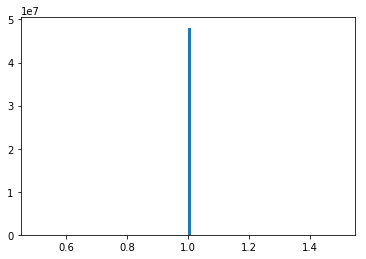

In [1]:
import heapq
import sys
import os
import argparse
import numpy as np
import pandas as pd
import warnings
import ujson as json
import logging as log
from copy import copy
from tqdm import tqdm_notebook as tqdm

###### Cython benign warning ignore ##########################
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
###############################################################

from pandas import DataFrame, Series
from os.path import expanduser, abspath, isfile, isdir, basename, splitext, \
	dirname, join, exists
from time import time
from datetime import date
import cPickle as pkl

#####################################
from datastructures.rgraph import Graph, weighted_degree
#####################################

from time import time
from os.path import exists, join, abspath, expanduser, basename, dirname, \
	isdir, splitext
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from scipy.sparse import save_npz, load_npz, csr_matrix

from datastructures.rgraph import make_graph, Graph
from datastructures.relationalpath import RelationalPath
from datastructures.relationalpath_sm import RelationalPathSM
from pathenum import get_paths as c_get_paths
## for streamminer,
from pathenum import get_paths_sm as c_get_paths_sm

##############################################
from algorithms.mincostflow.ssp import succ_shortest_path, disable_logging
from algorithms.relklinker.rel_closure import relational_closure as relclosure
from algorithms.sm.rel_closure_2 import relational_closure_sm as relclosure_sm
from algorithms.klinker.closure import closure
##############################################

###################################################################
################# DATABASE and RELSIM SETUP #######################
###################################################################
# KG - DBpedia
HOME = abspath(expanduser('~/Documents/streamminer/data/'))
if not exists(HOME):
	print 'Data directory not found: %s' % HOME
	print 'Download data per instructions on:'
	print '\thttps://github.com/shiralkarprashant/knowledgestream#data'
	print 'and enter the directory path below.'
	data_dir = raw_input('\nPlease enter data directory path: ')
	if data_dir != '':
		data_dir = abspath(expanduser(data_dir))
	if not os.path.isdir(data_dir):
		raise Exception('Entered path "%s" not a directory.' % data_dir)
	if not exists(data_dir):
		raise Exception('Directory does not exist: %s' % data_dir)
	HOME = data_dir
	# raise Exception('Please set HOME to data directory in algorithms/__main__.py')
PATH = join(HOME, 'kg/_undir/')
assert exists(PATH)
SHAPE = (6060993, 6060993, 663)
WTFN = 'logdegree'

# # relational similarity using TF-IDF representation and cosine similarity
# RELSIMPATH = join(HOME, 'relsim/coo_mat_sym_2016-10-24_log-tf_tfidf.npy')
# assert exists(RELSIMPATH)
##############################################################
RELSIMPATH = join(HOME, 'relsim/coo_mat_sym_2016-10-24_log-tf_tfidf.npy')
assert exists(RELSIMPATH)
##############################################################
# relational similarity using TF-IDF representation and cosine similarity

# relsim = np.load(RELSIMPATH)

# Date
DATE = '{}'.format(date.today())

# data types for int and float
_short = np.int16
_int = np.int32
_int64 = np.int64
_float = np.float

%matplotlib inline
import matplotlib.pyplot as plt
import heapq
inf = float('inf')

relsim = np.load(RELSIMPATH)

outdir = abspath(expanduser('output/'))
assert exists(outdir)
datafile = abspath(expanduser('datasets/sample.csv'))
assert exists(datafile)
log.info('Launching {}..'.format('SM'))
log.info('Dataset: {}'.format(basename(datafile)))
log.info('Output dir: {}'.format(outdir))

# read data
df = pd.read_table(datafile, sep=',', header=0)
log.info('Read data: {} {}'.format(df.shape, basename(datafile)))
spo_df = df.dropna(axis=0, subset=['sid', 'pid', 'oid'])
log.info('Note: Found non-NA records: {}'.format(spo_df.shape))
df = spo_df[['sid', 'pid', 'oid']].values
subs, preds, objs  = df[:,0].astype(_int), df[:,1].astype(_int), df[:,2].astype(_int)

# load knowledge graph
G = Graph.reconstruct(PATH, SHAPE, sym=True) # undirected
assert np.all(G.csr.indices >= 0)
base = splitext(basename(datafile))[0]


def weighted_degree(arr, weight='logdegree'):
	"""Returns a weighted version of the array."""
	if weight == 'degree':
		arr = 1./(1 + arr)
	elif weight == 'logdegree':
		arr = 1./(1 + np.log(arr))
	else:
		raise ValueError('Unknown weight function.')
	return arr

print "Shape of the data array: {}".format(G.csr.data.shape) #Undirected graph
print "Shape of the indices array: {}".format(G.csr.indices.shape) # for all the data points, there is one
print "Shape of the indptr array: {}".format(G.csr.indptr.shape) # for all the 6M entities
# To get an item on a particular position, just perform indexing on the self.csr matrix [node_row, rel_num * G.N + col_num]
plt.hist(G.csr.data, bins=100)
plt.show()

## Some settings for SM

PID is: 599.0, with type: float64
Specificity_wt has the shape: (48091479,)


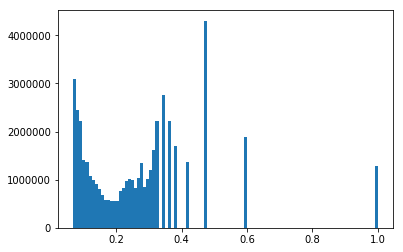

In [2]:
triples = spo_df
y = triples['class'] # ground truth
triples = triples[['sid', 'pid', 'oid']].to_dict(orient='records')

pid_removal = triples[0]['pid']
print 'PID is: {}, with type: {}'.format(pid_removal, pid_removal.dtype)
###############################c##############################################
indegsim = weighted_degree(G.indeg_vec, weight=WTFN).reshape((1, G.N))
indegsim = indegsim.ravel()
targets = G.csr.indices % G.N #target nodes are the node values that would occur in the first E x E matrix
specificity_wt = indegsim[targets]
print "Specificity_wt has the shape: {}".format(specificity_wt.shape)
plt.hist(specificity_wt, bins=100)
plt.show()
################################################################

#### Finding the relsim vector corresponding to predicate, p

Expected shape of the relsimvec is: (663,)
Shape of relsim_wt is: (48091479,)


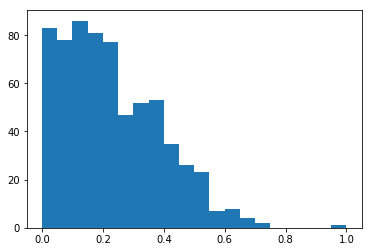

array([599])

In [3]:
relations = (G.csr.indices - targets) / G.N #gives the respective relation values of those indices
relsimvec = np.array(relsim[int(pid_removal), :]) # specific to predicate p
print "Expected shape of the relsimvec is: {}".format(relsimvec.shape)
relsim_wt = relsimvec[relations] # with the size of relations as the number of relations
print "Shape of relsim_wt is: {}".format(relsim_wt.shape)
# Binning the cosine similarity plot
plt.hist(relsimvec, bins=20)
plt.show()
np.unique(np.where(relsimvec == 1))

#### Removing the edge corresponding to p in the specificity matrix (soon to be data matrix)

=> Removing predicate 599.0 from KG.


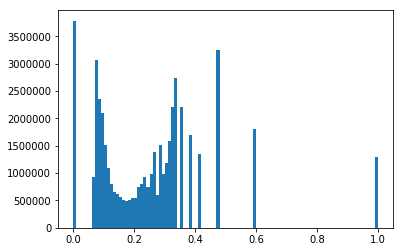

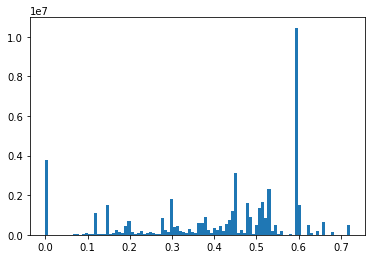

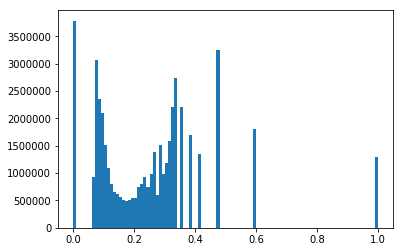

Number of 1 entries before oid specific ones: 1287481


In [4]:
print '=> Removing predicate {} from KG.'.format(pid_removal)
eraseedges_mask = ((G.csr.indices - (G.csr.indices % G.N)) / G.N) == int(pid_removal)
specificity_wt[eraseedges_mask] = 0
relsim_wt[eraseedges_mask] = 0
plt.hist(specificity_wt, bins=100, label='specificity')
plt.show()
plt.hist(relsim_wt, bins=100, label='relsim wrt to, {}'.format(pid_removal))
plt.show()
G.csr.data = specificity_wt.copy()
plt.hist(G.csr.data, bins=100)
plt.show()
# data has still 48M entries, but some of th1`ese indices now refer to 0 data point. The data point is not removed, it still stays.
print "Number of 1 entries before oid specific ones: {}".format(np.sum(G.csr.data == 1))

##### Final construction of data_matrix

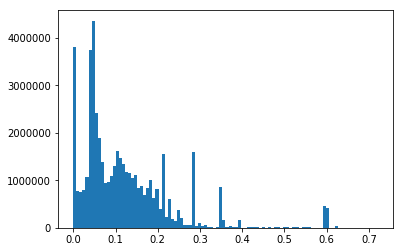

Total sum caused by 599.0 is 0.0


In [5]:
targets = G.csr.indices % G.N
G.csr.data = np.multiply(relsim_wt, G.csr.data)
plt.hist(G.csr.data, bins=100)
plt.show()
print "Total sum caused by {} is {}".format(pid_removal, np.sum(G.csr.data[relations == pid_removal]))
G_bak = {
'data': G.csr.data.copy(),
'indices': G.csr.indices.copy(),
'indptr': G.csr.indptr.copy()
}

### Building of adjacency list (2mins)

In [ ]:
len(relations), len(targets), len(G.csr.data), len(G.csr.indptr)
adj_list_s = []
adj_list_p = []
adj_list_o = []
sel_data = np.array([])
sel_relations = np.array([])
dicti = {}
num_nodes = len(G.csr.indptr)-1
for node in tqdm(xrange(num_nodes)):
    dicti = {}
    start = G.csr.indptr[node]
    end = G.csr.indptr[node+1]
    
    sel_data = G.csr.data[start:end]
    sel_relations = relations[start:end]
    for i, sel_tar in enumerate(targets[start:end]):
        if sel_tar in dicti:
            if dicti[sel_tar][0] < sel_data[i]:
                dicti[sel_tar] = (sel_data[i], sel_relations[i])
        else:
            dicti[sel_tar] = (sel_data[i], sel_relations[i])
    for key, value in dicti.iteritems():
        if value[0] != 0:
            adj_list_data.append(value[0])
            adj_list_s.append(node)
            adj_list_p.append(value[1])
            adj_list_o.append(key)
G_fil_rel = csr_matrix((adj_list_p, (adj_list_s, adj_list_o)), shape=(num_nodes, num_nodes))
G_fil_val = csr_matrix((adj_list_data, (adj_list_s, adj_list_o)), shape=(num_nodes, num_nodes))
save_npz(join(HOME, 'sm', 'G_fil_rel.npz'), G_fil_rel)
save_npz(join(HOME, 'sm', 'G_fil_val.npz'), G_fil_val)

In [9]:
# Testing
################################################################
G_fil_rel = load_npz(join(HOME, 'sm', 'G_fil_rel_599.npz'))
G_fil_val = load_npz(join(HOME, 'sm', 'G_fil_val_599.npz'))
################################################################

In [7]:
def delete_node(G_fil_val, G_fil_rel, s):
    # for now it just deletes outward edges from the s node
    s = int(s)
    deletedNodes = []
    start = G_fil_rel.indptr[s]
    end = G_fil_rel.indptr[s+1]
    tmp = G_fil_val.data[start:end]
    # deleting data values
    G_fil_val.data[start:end] = np.inf
    deletedNodes.append((s, tmp))
    return deletedNodes

def add_node(G_fil_val, G_fil_rel, removedNodes):
    for removedNode in removedNodes:
        start = G_fil_rel.indptr[removedNode[0]]
        end = G_fil_rel.indptr[removedNode[0]+1]
        G_fil_val.data[start:end] = removedNode[1]

def delete_edge(G_fil_val, G_fil_rel, s, p, o):
    s, p, o = int(s), int(p), int(o)
    deletedEdges = []
    
    # deleting the edge: s --> o
#     print "removing edge from {} to {}".format(s, o)
    start = G_fil_rel.indptr[s]
    end = G_fil_rel.indptr[s+1]
    neighbors = G_fil_rel.indices[start:end]
    rels = G_fil_rel.data[start:end]
    pos = start + np.where(np.logical_and(neighbors == o, rels == p))
    
    deletedEdges.append((s, o, p, G_fil_val.data[pos]))
    G_fil_val.data[pos] = np.inf
    
    # deleting the edge: o --> s
#     print "removing edge from {} to {}".format(o, s)
    start = G_fil_rel.indptr[o]
    end = G_fil_rel.indptr[o+1]
    neighbors = G_fil_rel.indices[start:end]
    rels = G_fil_rel.data[start:end]
    pos = start + np.where(np.logical_and(neighbors == s, rels == p))
    
    deletedEdges.append((o, s, p, G_fil_val.data[pos]))
    G_fil_val.data[pos] = np.inf
    
    return deletedEdges

def add_edge(G_fil_val, G_fil_rel, removed_edges):
    for removed_edge in removed_edges:
        s, o, p, cost = removed_edge
#         print "adding edge from {} to {}".format(s, o)
        start = G_fil_rel.indptr[s]
        end = G_fil_rel.indptr[s+1]
        neighbors = G_fil_rel.indices[start:end]
        rels = G_fil_rel.data[start:end]
        G_fil_val.data[start + np.where(np.logical_and(neighbors == o, rels == p))] = cost

def yenKSP5(G_fil_rel, G_fil_val, sid, pid, oid, K = 5):
    discovered_paths = []
    weight_stack, path_stack, rel_stack = relclosure_sm(G_fil_val, G_fil_rel, int(sid), int(pid), int(oid), kind='metric', linkpred = False)
    if rel_stack == [-1]:
        ## if the first shortest path is empty, retuen empty discoverd_paths
        return discovered_paths
    A = [{'path_total_cost': np.sum(weight_stack[:-1]),
          'path': path_stack,
          'path_rel': rel_stack,
          'path_weights': weight_stack}]
#     print A
    B = []
    removed_edges = []
    removed_nodes = []
    for k in xrange(1, K): #for the k-th path, it assumes all paths 1..k-1 are available
        for i in xrange(0, len(A[-1]['path'])-1):
            # the spurnode ranges from first node of the previous (k-1) shortest path to its next to last node.
            spurNode = A[-1]['path'][i]
#             print "SpurNode{}"spurNode
            rootPath = A[-1]['path'][:i+1]
            rootPathRel = A[-1]['path_rel'][:i+1]
            rootPathWeights = A[-1]['path_weights'][:i+1]
#             print "SpurNode: {}, Rootpath: {}".format(spurNode, rootPath)
            removed_edges[:] = []
            removed_nodes[:] = []
            for path_dict in A:
                if len(path_dict['path']) > i and rootPath == path_dict['path'][:i+1]:
                    removed_edges.extend( delete_edge(G_fil_val, G_fil_rel, path_dict['path'][i], path_dict['path_rel'][i+1], path_dict['path'][i+1]) )
            for rootPathNode in rootPath[:-1]:
                removed_nodes.extend( delete_node(G_fil_val, G_fil_rel, rootPathNode) )
            spurPathWeights, spurPath, spurPathRel = relclosure_sm(G_fil_val, G_fil_rel, int(spurNode), int(pid), int(oid), kind='metric', linkpred = False)
            if spurPath and spurPathRel != [-1]:
                totalPath = rootPath[:-1] + spurPath
                totalDist = np.sum(rootPathWeights[:-1]) + np.sum(spurPathWeights[:-1])
                totalWeights = rootPathWeights[:-1] + spurPathWeights[:]
                totalPathRel = rootPathRel[:] + spurPathRel[1:]
                potential_k = {'path_total_cost': totalDist,
                               'path': totalPath,
                               'path_rel': totalPathRel,
                               'path_weights': totalWeights}
#                 print potential_k
                if not (potential_k in B or potential_k in A) :
                    # removes repititive paths in A & B
                    B.append(potential_k)
            removed_nodes.reverse()
            add_node(G_fil_val, G_fil_rel, removed_nodes)
            removed_edges.reverse()
            add_edge(G_fil_val, G_fil_rel, removed_edges)
            sys.stdout.flush()
        if len(B):
            B = sorted(B, key=lambda k: k['path_total_cost'])
            A.append(B[0])
            # log.debug("totalPath: {}, totalPathRel: {}".format(B[0]['path'], B[0]['path_rel']))
            B.pop(0)
        else:
            break
    for path_dict in A:
        discovered_paths.append(RelationalPathSM(sid, pid, oid, path_dict['path_total_cost'], len(path_dict['path'])-1, path_dict['path'], path_dict['path_rel'], path_dict['path_weights']))
    return discovered_paths

In [8]:
def extract_paths_sm(G_fil_val, G_fil_rel, triples, y, features=None):
    return_features = False
    if features is None:
        return_features = True
        features, pos_features, neg_features = set(), set(), set()
    measurements = []

    for idx, triple in enumerate(tqdm(triples)):
        sid, pid, oid = triple['sid'], triple['pid'], triple['oid']
        label = y[idx]
        triple_feature = dict()
        discovered_paths = yenKSP5(G_fil_rel, G_fil_val, sid, pid, oid, K = 5)
        for path in discovered_paths:
            print path
            ff = tuple(path.relational_path)
            if ff not in features:
                features.add(ff)
                if label == 1:
                    pos_features.add(ff)
                elif label == 0:
                    neg_features.add(ff)
                else:
                    raise Exception("Unknown class label: {}".format(label))
            triple_feature[ff] = triple_feature.get(ff, 0) + 1
        measurements.append(triple_feature)
    print ''
    if return_features:
        return features, pos_features, neg_features, measurements
    return measurements

features, pos_features, neg_features, measurements = extract_paths_sm(G_fil_val, G_fil_rel, triples, y)

SPO: [ 392035.0 599.0 2115741.0], Score: 0.0677970562743, Path (1):[392035] -189 (0.07)-> [2115741]
SPO: [ 392035.0 599.0 2115741.0], Score: 0.129642864833, Path (3):[392035] -660 (0.03)-> [78] -660 (0.04)-> [4475218] -236 (0.06)-> [2115741]
SPO: [ 392035.0 599.0 2115741.0], Score: 0.227870891895, Path (3):[392035] -660 (0.03)-> [78] -660 (0.06)-> [532169] -236 (0.14)-> [2115741]
SPO: [ 392035.0 599.0 2115741.0], Score: 0.32246592914, Path (5):[392035] -660 (0.03)-> [78] -660 (0.04)-> [4475218] -236 (0.04)-> [3040313] -236 (0.08)-> [532169] -236 (0.13)-> [2115741]
SPO: [ 392035.0 599.0 2115741.0], Score: 0.292163189332, Path (5):[392035] -660 (0.03)-> [78] -660 (0.04)-> [4475218] -236 (0.04)-> [1006463] -236 (0.07)-> [532169] -236 (0.11)-> [2115741]
SPO: [ 482030.0 599.0 2364618.0], Score: 0.0709806674345, Path (1):[482030] -189 (0.07)-> [2364618]
SPO: [ 482030.0 599.0 2364618.0], Score: 0.189150057923, Path (3):[482030] -462 (0.04)-> [4160079] -462 (0.07)-> [4107784] -189 (0.08)-> [23

SPO: [ 1670176.0 599.0 3218267.0], Score: 0.0691551371972, Path (1):[1670176] -189 (0.07)-> [3218267]
SPO: [ 1670176.0 599.0 3218267.0], Score: 0.36068501687, Path (5):[1670176] -123 (0.03)-> [4628295] -601 (0.04)-> [2944879] -418 (0.05)-> [584900] -431 (0.09)-> [5205802] -601 (0.15)-> [3218267]
SPO: [ 1670176.0 599.0 3218267.0], Score: 0.288822689762, Path (5):[1670176] -123 (0.02)-> [1257183] -194 (0.03)-> [2902285] -311 (0.04)-> [4110879] -480 (0.07)-> [2634517] -311 (0.12)-> [3218267]
SPO: [ 1670176.0 599.0 3218267.0], Score: 0.289872465037, Path (5):[1670176] -123 (0.03)-> [4628295] -601 (0.04)-> [2944879] -418 (0.05)-> [584900] -418 (0.06)-> [4833954] -601 (0.11)-> [3218267]
SPO: [ 1670176.0 599.0 3218267.0], Score: 0.30167518834, Path (5):[1670176] -123 (0.02)-> [1257183] -194 (0.03)-> [2671770] -311 (0.04)-> [4110879] -480 (0.06)-> [2634517] -311 (0.15)-> [3218267]
SPO: [ 1940481.0 599.0 4628461.0], Score: 0.0735669510738, Path (1):[1940481] -189 (0.07)-> [4628461]
SPO: [ 19404

KeyboardInterrupt: 

In [ ]:
def predpath_train_model_sm(G_fil_val, G_fil_rel, triples, relsim, use_interpretable_features=False, cv=10):
    y = triples['class'] # ground truth
    triples = triples[['sid', 'pid', 'oid']].to_dict(orient='records')
    pid = triples[0]['pid']
    log.info('PID is: {}, with type: {}'.format(pid, pid.dtype))
    #print 'PID is: {}, with type: {}'.format(pid, pid.dtype)
    
	############# Path extraction ###################
	log.info('=> Path extraction..(this can take a while)')
	t1 = time()
	features, pos_features, neg_features, measurements = extract_paths_sm(G_fil_val, G_fil_rel, triples, y)
	log.info('P: +:{}, -:{}, unique tot:{}'.format(len(pos_features), len(neg_features), len(features)))
	vec = DictVectorizer()
	X = vec.fit_transform(measurements)
	n, m = X.shape
	log.info('Time taken: {:.2f}s\n'.format(time() - t1))
	print ''

	########### Path selection ###############
	log.info('=> Path selection..')
	t1 = time()
	pathselect = SelectKBest(mutual_info_classif, k=min(100, m))
	X_select = pathselect.fit_transform(X, y)
	selectidx = pathselect.get_support(indices=True) # selected feature indices
	vec = vec.restrict(selectidx, indices=True)
	select_pos_features, select_neg_features = set(), set()
	for feature in vec.get_feature_names():
		if feature in pos_features:
			select_pos_features.add(feature)
		if feature in neg_features:
			select_neg_features.add(feature)
	log.info('D: +:{}, -:{}, tot:{}'.format(len(select_pos_features), len(select_neg_features), X_select.shape[1]))
	log.info('Time taken: {:.2f}s\n'.format(time() - t1))
	print ''

	# Fact interpretation
	if use_interpretable_features and len(select_neg_features) > 0:
		log.info('=> Fact interpretation..')
		#print '=> Fact interpretation..'
		t1 = time()
		theta = 10
		select_neg_idx = [i for i, f in enumerate(vec.get_feature_names()) if f in select_neg_features]
		removemask = np.where(np.sum(X_select[:, select_neg_idx], axis=0) >= theta)[0]
		restrictidx = select_neg_idx[removemask]
		keepidx = []
		for i, f in enumerate(vec.get_feature_names()):
			if i not in restrictidx:
				keepidx.append(i)
			else:
				select_neg_features.remove(f)
		vec = vec.restrictidx(keepidx, indices=True)
		X_select = X_select[:, keepidx]
		log.info('D*: +:{}, -:{}, tot:{}'.format(len(select_pos_features), len(select_neg_features), X_select.shape[1]))
		log.info('Time taken: {:.2f}s\n'.format(time() - t1))
		#print 'D*: +:{}, -:{}, tot:{}'.format(len(select_pos_features), len(select_neg_features), X_select.shape[1])
		#print 'Time taken: {:.2f}s'.format(time() - t1)
		#print ''

	# Model creation
	log.info('=> Model building..')
	#print '=> Model building..'
	t1 = time()
	model = find_best_model(X_select, y, cv=cv)
	log.info('#Features: {}, best-AUROC: {:.5f}'.format(X_select.shape[1], model['best_score']))
	#print '#Features: {}, best-AUROC: {:.5f}'.format(X_select.shape[1], model['best_score'])
	log.info('Time taken: {:.2f}s\n'.format(time() - t1))
	#print 'Time taken: {:.2f}s'.format(time() - t1)
	#print ''

	return vec, model

In [ ]:
source_try = 392035
target_try = 2115741 
pred_try = 599
discovered_paths = yenKSP5(G_fil_rel, G_fil_val, source_try, pred_try, target_try, K = 5)
for path in discovered_paths:
    print path

In [11]:
G_fil_val.data[34] = np.inf